# Non-Pharmaceutical Interventions for COVID-19

In [1]:
%load_ext dotenv
%dotenv

In [2]:
# get raw data from GCP bucket
import numpy as np
import pandas as pd
import os
import glob
import json
from datetime import datetime
from google.cloud import storage

## Exploring Metadata
With over 13000 unique research papers provider by Kaggle, there is a csv file also included with the metadata for each paper. Data from this csv file will be extracted, cleaned and explored.

Data from Kaggle was upload into Google Cloud Storage (GCS). All data from now on is extracted from GCS.

In [15]:
# The bucket name for the location of the data is in the .env file
BUCKET_NAME = os.environ['BUCKET_NAME']
METADATA_FILE = 'all_sources_metadata_2020-03-13.csv'

In [16]:
# Pull in metadata csv file and convert to pandas dataframe
meta_df = pd.read_csv(f'gs://{BUCKET_NAME}/{METADATA_FILE}', encoding='utf-8', low_memory=False)
meta_df.head(2)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True


In [17]:
meta_df.source_x.value_counts(dropna=False)

PMC        27337
CZI         1236
biorxiv      566
medrxiv      361
Name: source_x, dtype: int64

In [18]:
# Clean numbers and special characters
regex_arr = ['\d','\t','\r','\)','\(','\/', ':', ';', '&', '#', '-', '\.']
def clean_numbers_and_special_characters (df, col):
    meta_df[col] = meta_df[col].replace(regex=regex_arr, value='')
    meta_df[col] = meta_df[col].str.rstrip()
    meta_df[col] = meta_df[col].str.lower()
    return meta_df    

meta_df = clean_numbers_and_special_characters(df, 'title')
meta_df = clean_numbers_and_special_characters(df, 'abstract')
meta_df = clean_numbers_and_special_characters(df, 'authors')
meta_df.head(2)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,angiotensinconverting enzyme ace as a sarscov...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"zhang, haibo penninger, josef m li, yimin zhon...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"cao, yanan li, lin feng, zhimin wan, shengqing...",Cell Discovery,3.003431e+09,#1861,True


In [19]:
keywords = ['incident command system',
            'emergency operations',
            'joint information center',
            'social distancing',
            'childcare closers',
            'travel advisory',
            'travel warning',
            'isolation',
            'qarentine',
            'mass gathering cancellations',
            'school closures',
            'facility closures',
            'facility closures',
            'evacuation',
            'relocation',
            'restricing travel',
            'travel ban',
            'patient cohort',
            'npi']

for word in keywords:
    meta_df[word + '_keyword'] = df['abstract'].str.find(word)

# df['social distancing_keyword'].value_counts(dropna=False)
meta_df.head(5)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,...,qarentine_keyword,mass gathering cancellations_keyword,school closures_keyword,facility closures_keyword,evacuation_keyword,relocation_keyword,restricing travel_keyword,travel ban_keyword,patient cohort_keyword,npi_keyword
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,angiotensinconverting enzyme ace as a sarscov...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"zhang, haibo penninger, josef m li, yimin zhon...",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"cao, yanan li, lin feng, zhimin wan, shengqing...",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,incubation period and other epidemiological ch...,10.3390/jcm9020538,NaN,NaN,cc-by,the geographic spread of novel coronavirus co...,2020,"linton, m natalie kobayashi, tetsuro yang, yic...",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,characteristics of and public health responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"in december , cases of unidentified pneumonia ...",2020,"deng, shengqun peng, hongjuan",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,imaging changes in severe covid pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"zhang, wei",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [21]:
keyword_cols = [word+'_keyword' for word in keywords]
keyword_cols
meta_df.loc[meta_df[keyword_cols].notna().all(axis=1) & ~(meta_df[keyword_cols] == -1.0).all(axis=1),'is_keyword'] = True

In [22]:
df_dropped = meta_df.drop("sha", axis=1).loc[meta_df['has_full_text'] == True].drop_duplicates()

In [23]:
df_dropped['social distancing_keyword'].value_counts()

-1.0       8789
 660.0        1
 384.0        1
 349.0        1
 305.0        1
 912.0        1
 2250.0       1
 1255.0       1
 471.0        1
 724.0        1
 284.0        1
 767.0        1
 95.0         1
 1714.0       1
 373.0        1
 796.0        1
 601.0        1
 439.0        1
 1008.0       1
 738.0        1
 599.0        1
Name: social distancing_keyword, dtype: int64

## Aggregate JSON
The json files are in four main folders:
- biorxiv_medrxiv
- comm_use_subset
- noncomm_use_subset
- pmc_custom_license  
All json files will be processed and aggregated into a pandas dataframe

In [4]:
class FileReader:
    def __init__(self, bucket_name):
        self.bucket_name = bucket_name
        storage_client = storage.Client()
        self.blobs = storage_client.list_blobs(bucket_name)

    def extract_all_json(self):
        json_dict = []
        start_time = datetime.now()
        for blob in self.blobs:
            if blob.name.endswith('.json'):
                elapsed_time = self._elapsed_time(start_time)
                if len(json_dict) % 500 == 0:
                    print(f'{len(json_dict)} json files processed: {elapsed_time}')
                data = json.loads(blob.download_as_string(client=None))
                author_list = self._extract_name_list(data)
                abstract  = self._extract_json_text(data, 'abstract')
                body_text  = self._extract_json_text(data, 'body_text')
                json_dict.append({'paper_id': data['paper_id'],
                                  'title': data['metadata']['title'].lower().strip(),
                                  'author_list': author_list,
                                  'abstract': abstract,
                                  'body_text': body_text})
        elapsed_time = self._elapsed_time(start_time)
        print(f'{len(json_dict)} json files processed in total: {elapsed_time}')
        return pd.DataFrame(json_dict)
    
    def _extract_name_list(self, data):
        name_list = []
        for a in data['metadata']['authors']:
            first = a['first']
            middle = ''
            if a['middle']:
                middle = a['middle'][0] + ' '
            last = a['last']
            name_list.append(f'{first} {middle}{last}')
        return name_list
    
    def _extract_json_text(self, data, key):
        return ' '.join(str(item['text']).lower().strip() for item in data[key])
    
    def _elapsed_time(self, start):
        elapsed = datetime.now() - start
        total_seconds = elapsed.total_seconds()
        hours = int(total_seconds // 3600)
        minutes = int((total_seconds % 3600) // 60)
        seconds = int(total_seconds % 60)
        time = '{} hours, {} minutes, {} seconds'.format(hours, minutes, seconds)
        return time

In [5]:
file = FileReader(BUCKET_NAME)
df = file.extract_all_json()

0 json files processed: 0 hours, 0 minutes, 0 seconds
500 json files processed: 0 hours, 0 minutes, 33 seconds
1000 json files processed: 0 hours, 1 minutes, 6 seconds
1500 json files processed: 0 hours, 1 minutes, 42 seconds
2000 json files processed: 0 hours, 2 minutes, 56 seconds
2500 json files processed: 0 hours, 4 minutes, 12 seconds
3000 json files processed: 0 hours, 5 minutes, 28 seconds
3500 json files processed: 0 hours, 6 minutes, 42 seconds
4000 json files processed: 0 hours, 7 minutes, 58 seconds
4500 json files processed: 0 hours, 9 minutes, 14 seconds
5000 json files processed: 0 hours, 10 minutes, 33 seconds
5500 json files processed: 0 hours, 11 minutes, 48 seconds
6000 json files processed: 0 hours, 13 minutes, 3 seconds
6500 json files processed: 0 hours, 14 minutes, 18 seconds
7000 json files processed: 0 hours, 15 minutes, 33 seconds
7500 json files processed: 0 hours, 16 minutes, 45 seconds
8000 json files processed: 0 hours, 17 minutes, 57 seconds
8500 json file

In [6]:
df.head()

,abstract,author_list,body_text,paper_id,title
0,word count: 194 22 text word count: 5168 23 24...,"[Joseph C Ward, Lidia Lasecka-Dykes, Chris Nei...","vp3, and vp0 (which is further processed to vp...",0015023cc06b5362d332b3baf348d11567ca2fbb,the rna pseudoknots in foot-and-mouth disease ...
1,,"[Hanchu Zhou, Jiannan Yang, Kaicheng Tang, † ,...",the 2019-ncov epidemic has spread across china...,004f0f8bb66cf446678dc13cf2701feec4f36d76,healthcare-resource-adjusted vulnerabilities t...
2,infectious bronchitis (ib) causes significant ...,"[Salman L Butt, Eric C Erwood, Jian Zhang, Hol...","infectious bronchitis (ib), which is caused by...",00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,"real-time, minion-based, amplicon sequencing f..."
3,background: a novel coronavirus (2019-ncov) em...,"[Shengjie Lai, Isaac I Bogoch, Nick W Ruktanon...","in december 2019, a cluster of patients with p...",013d9d1cba8a54d5d3718c229b812d7cf91b6c89,assessing spread risk of wuhan novel coronavir...
4,faced with the current large-scale public heal...,"[Xiaoyang Ji, Chunming Zhang, Yubo Zhai, Zhong...",the sudden outbreak of the new coronavirus (sa...,01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,"twirls, an automated topic-wise inference meth..."


Since the extraction of json files to a pandas dataframe took about 30 minutes, the dataframe will be pickled so the `FileReader` does not need to be run every time to explore the dataset

In [9]:
# pickle the file
import pickle
df.to_pickle('./all_json.pkl')

In [13]:
all_json_df = pd.read_pickle('./all_json.pkl')

In [14]:
all_json_df.head()

,abstract,author_list,body_text,paper_id,title
0,word count: 194 22 text word count: 5168 23 24...,"[Joseph C Ward, Lidia Lasecka-Dykes, Chris Nei...","vp3, and vp0 (which is further processed to vp...",0015023cc06b5362d332b3baf348d11567ca2fbb,the rna pseudoknots in foot-and-mouth disease ...
1,,"[Hanchu Zhou, Jiannan Yang, Kaicheng Tang, † ,...",the 2019-ncov epidemic has spread across china...,004f0f8bb66cf446678dc13cf2701feec4f36d76,healthcare-resource-adjusted vulnerabilities t...
2,infectious bronchitis (ib) causes significant ...,"[Salman L Butt, Eric C Erwood, Jian Zhang, Hol...","infectious bronchitis (ib), which is caused by...",00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,"real-time, minion-based, amplicon sequencing f..."
3,background: a novel coronavirus (2019-ncov) em...,"[Shengjie Lai, Isaac I Bogoch, Nick W Ruktanon...","in december 2019, a cluster of patients with p...",013d9d1cba8a54d5d3718c229b812d7cf91b6c89,assessing spread risk of wuhan novel coronavir...
4,faced with the current large-scale public heal...,"[Xiaoyang Ji, Chunming Zhang, Yubo Zhai, Zhong...",the sudden outbreak of the new coronavirus (sa...,01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,"twirls, an automated topic-wise inference meth..."


## Exploring ALL Research Papers

In [30]:
meta_df[meta_df.sha == '0015023cc06b5362d332b3baf348d11567ca2fbb']['abstract'][28966]

"the positive stranded rna genomes of picornaviruses comprise a single large open reading frame flanked by ' and ' untranslated regions utrs footandmouth disease virus fmdv has an unusually large ' utr  kb containing five structural domains these include the internal ribosome entry site ires, which facilitates initiation of translation, and the cisacting replication element cre less well characterised structures are a ' terminal  nucleotide stemloop, a variable length polyctract of approximately  nucleotides and a series of two to four tandemly repeated pseudoknots pks we investigated the structures of the pks by selective ' hydroxyl acetylation analysed by primer extension shape analysis and determined their contribution to genome replication by mutation and deletion experiments shape and mutation experiments confirmed the importance of the previously predicted pk structures for their function deletion experiments showed that although pks are not essential for replication, they provid

In [29]:
all_json_df[all_json_df.paper_id == '0015023cc06b5362d332b3baf348d11567ca2fbb']['abstract'][0]

'word count: 194 22 text word count: 5168 23 24 25 author/funder. all rights reserved. no reuse allowed without permission. abstract 27 the positive stranded rna genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (utrs). foot-and-mouth disease virus (fmdv) 29 has an unusually large 5′ utr (1.3 kb) containing five structural domains. these include the 30 internal ribosome entry site (ires), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-c-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (pks). we investigated the structures of the pks 34 by selective 2′ hydroxyl acetylation analysed by primer extension (shape) analysis and 35 determined their contribution to genome replication by mutation and deletion experiments. 36 shap

In [31]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
from nltk.corpus import stopwords

In [45]:
def display_wordcloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

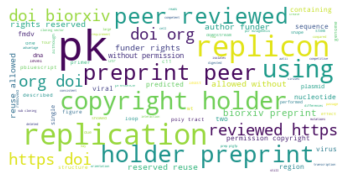

In [48]:
display_wordcloud(all_json_df.body_text[0])